In [55]:
import os
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle
import io
from PIL import Image
from warnings import filterwarnings

In [56]:
X_train = []
y_train = []
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


image_size = 256
for i in labels:
    folderPath = os.path.join('/Users/leahnewmark/Desktop/Leah/ML-Capstone/Tumor imaging ML capstone/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/Users/leahnewmark/Desktop/Leah/ML-Capstone/Tumor imaging ML capstone/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 404.20it/s]


In [57]:
# Print the shapes and counts
print(f"Total number of images in X_train: {X_train.shape[0]}")
print(f"Total number of labels in y_train: {y_train.shape[0]}")

# Print the shape of images
print(f"Shape of images: {X_train.shape[1:]}")

# Optional: Verify if the number of labels matches the number of images
if X_train.shape[0] == y_train.shape[0]:
    print("The number of images matches the number of labels.")
else:
    print("There is a mismatch between the number of images and labels.")

Total number of images in X_train: 3264
Total number of labels in y_train: 3264
Shape of images: (256, 256, 3)
The number of images matches the number of labels.


Visualizatioin

Glioma Tumor:

Originating in the brain or spine's glial cells, gliomas represent 30% of all brain and central nervous system tumors. They are mostly malignant, with symptoms that vary depending on location, frequently resulting in seizures, cognitive impairments, or motor deficits.

Meningioma Tumor:

Meningiomas, arising from the meninges enveloping the brain and spinal cord, are slow-growing tumors. While they typically are asymptomatic, they can cause seizures, cognitive decline, vision disturbances, or motor deficits depending on their location.

Pituitary Tumor:

Pituitary adenomas, mostly benign, occur in the pituitary gland, accounting for 10-25% of intracranial neoplasms. They may cause hormonal imbalances, resulting in a variety of symptoms including headaches, vision changes, or hormonal dysfunctions.

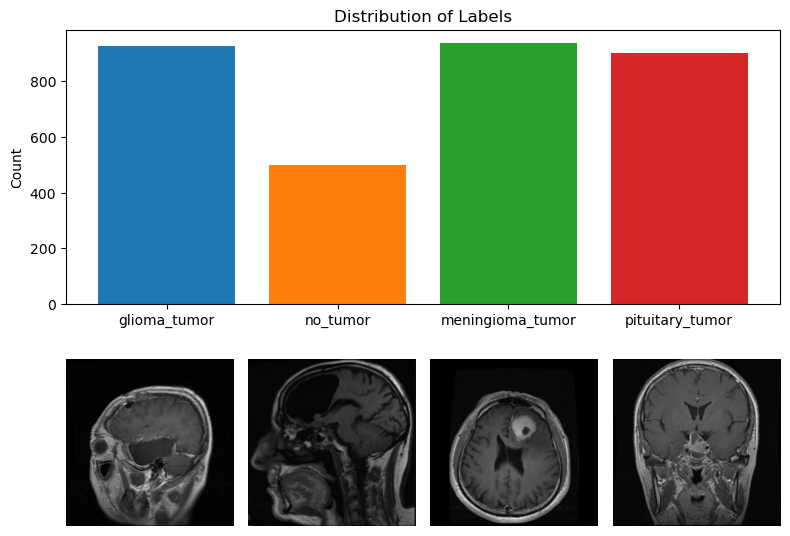

In [58]:
# Calculate the bar plot for each label
label_counts = {label: np.sum(y_train == label) for label in labels}

# Plot the bar plot and sample images in one chart
plt.figure(figsize=(8, 6))

colors = ["C0", "C1", "C2", "C3"]

# Plot the histogram
plt.subplot(2, 1, 1)
bars = plt.bar(label_counts.keys(), label_counts.values(), color=colors)

# plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Plot sample images from each label
k = 0
for i in labels:
    j = 0
    while True:
        if y_train[j] == i:
            plt.subplot(2, 4, k + 5) 
            plt.imshow(X_train[j])
            plt.axis('off')
            k += 1
            break
        j += 1
        
plt.tight_layout()
plt.show()

Data augmentation

Data augmentation is an important technique in deep learning for increasing and diversifying existing datasets. Instead of collecting new data, it involves transforming existing data to generate variations. This approach addresses the need for large and diverse datasets, which are required to train robust deep learning models. By augmenting the data, we can effectively increase dataset sizes and diversity, thereby improving the model's ability to generalize to different scenarios.
Source:geeksforgeeks


arrow_upwardarrow_downwarddelete
Overly extreme augmentation parameters can distort images, limiting the model's ability to generalize. For example, excessive rotation or zooming can obscure important image features, resulting in misclassifications.

In [59]:
#data augmentation with datagen

datagen = ImageDataGenerator(
    rotation_range=20,            # Randomly rotate images by up to 20 degrees.
    width_shift_range=0.1,        # Randomly shift images horizontally by up to 10% of the width.
    height_shift_range=0.1,       # Randomly shift images vertically by up to 10% of the height.
    zoom_range=0.1,               # Randomly zoom images by up to 10%.
    horizontal_flip=False,        # Do not randomly flip images horizontally.
    vertical_flip=False,          # Do not randomly flip images vertically.
    fill_mode='nearest'           # Fill in missing pixels with the nearest pixel value.
)

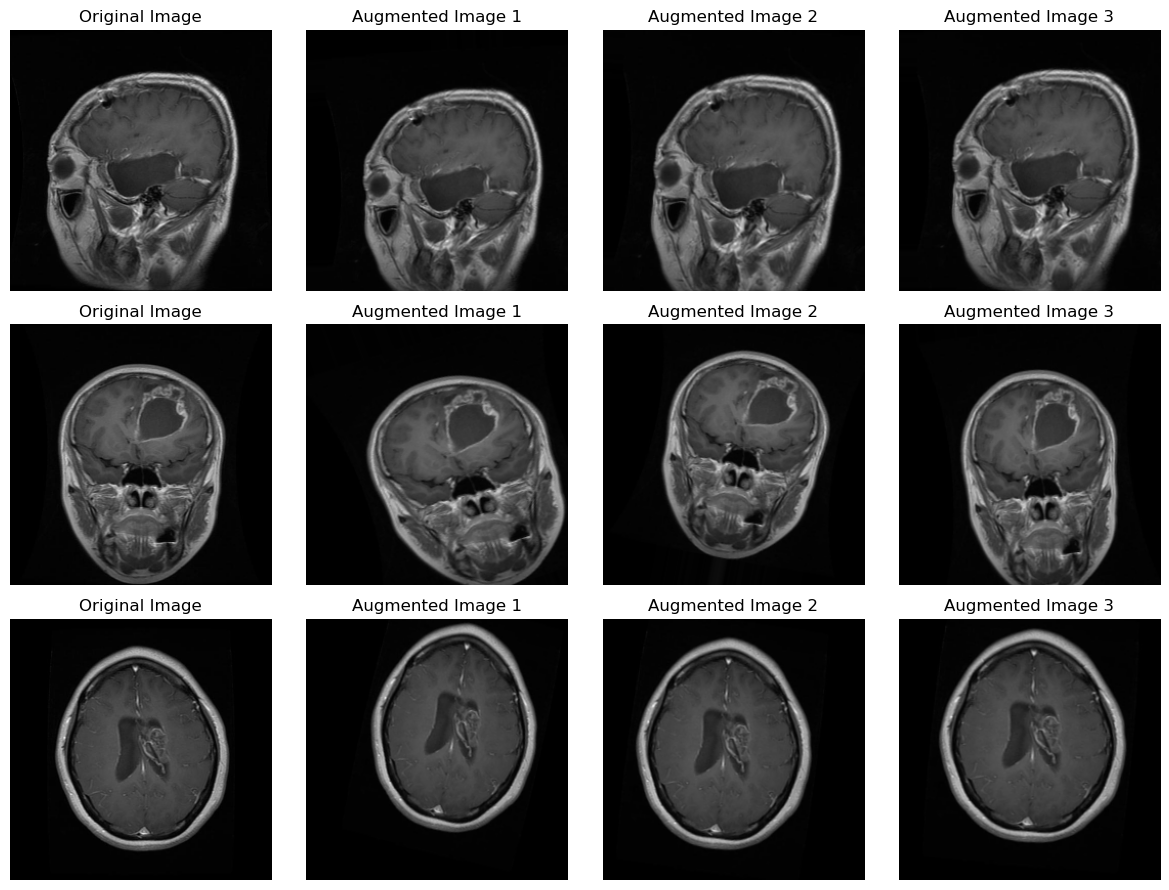

In [60]:
def visualize_augmented_images(image_generator, num_samples, num_augmented_images):
    augmented_images = []
    for sample in X_train[:num_samples]:
        
        # Create a list to store augmented versions of a sample
        augmented_samples = [sample]
        for _ in range(num_augmented_images):
            augmented_samples.append(image_generator.random_transform(sample))
        augmented_images.append(augmented_samples)

    # Plot original and augmented images
    fig, axes = plt.subplots(num_samples, num_augmented_images + 1, figsize=( 12, num_samples * 3))
    for i, sample in enumerate(augmented_images):
        for j, image in enumerate(sample):
            axes[i,j].imshow(image)
            if j == 0:
                axes[i, j].set_title('Original Image')
            else:
                axes[i,j].set_title(f'Augmented Image {j}')
            axes[i, j].axis('off')
            
    plt.tight_layout()
    plt.show()

#Visualize augmented images to see how it works
visualize_augmented_images(datagen, num_samples=3, num_augmented_images=3)

In [61]:
# Convert y_train labels to one-hot encoded format using pandas
y_train = np.array(pd.get_dummies(y_train))

#Split the dataset into training, testing and validation sets
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_test shape: {(X_test).shape}\n'
      f'y_test shape: {(y_test).shape}\n'
      f'X_Valid shape: {(X_valid).shape}\n'
      f'y_valid shape: {(y_valid).shape}')

X_train shape: (2643, 256, 256, 3)
y_train shape: (2643, 4)
X_test shape: (327, 256, 256, 3)
y_test shape: (327, 4)
X_Valid shape: (294, 256, 256, 3)
y_valid shape: (294, 4)


In [62]:
# Normalize pixel values of training images to the range [0,1]
X_train = X_train / 255
X_test = X_test / 255
X_valid = X_valid / 255

print(f"Maximum and Minimum pixel value after normalization: {X_train.max()} - {X_train.min()}")

Maximum and Minimum pixel value after normalization: 1.0 - 0.0


Convolution Neural Network

In a Convolutional Neural Network, various layers work to process input data, such as images. The Convolutional layer extracts features using filters, the Pooling layer reduces image size to improve efficiency, and the fully connected layer makes predictions. Backpropagation and gradient descent are used by the network to refine its filter parameters and improve its performance.

Input Layer (Input(shape=(256, 256, 3))):
This defines the input shape of the images (256x256 pixels with 3 color channels for RGB).

Convolutional Layers (Conv2D):
Purpose: These layers extract features from the image by applying filters (kernels). The number of filters grows deeper in the network to capture more complex features.

MaxPooling Layers (MaxPooling2D):
Purpose: These layers reduce the spatial dimensions (height and width) of the feature maps, downsampling to focus on the most important information and reduce computational cost. Pooling helps prevent overfitting by adding a form of spatial invariance.

Dropout Layers (Dropout):
Purpose: Dropout randomly "drops" (turns off) a fraction of neurons during training to prevent overfitting. The values are set at 0.2 (20%) and 0.3 (30%) in different layers.

Flatten Layer (Flatten()):
Purpose: This converts the 2D feature maps into a 1D vector that can be passed into fully connected (Dense) layers.

Fully Connected (Dense) Layers:
Dense(128): After flattening, this layer has 128 neurons with the ReLU activation function to introduce non-linearity and process the feature vector.
Dense(4, activation='softmax'): The output layer uses 4 neurons (since there are 4 classes), and softmax is used to output probabilities for multiclass classification.

In [65]:
from tensorflow.keras.optimizers.legacy import Adam #use for Mac OS

# Define the model
model = Sequential()

# An Input layer specifying the input shape
model.add(Input(shape=(256, 256, 3)))

# Conv2D(16, kernel_size=(5,5)): The first two convolutional layers use 16 filters of 
# size 5x5 to capture basic features like edges or simple textures.
model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(16, kernel_size=(5,5), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

# Conv2D(32, kernel_size=(3,3)): The next two layers use 32 filters of size 3x3, 
# which is smaller but processes more complex features.
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

# Conv2D(64, kernel_size=(3,3)): The final convolutional layer increases to 
# 64 filters to capture even more abstract features before flattening.
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))   # the Softmax function works for multiclass classification problems 
                                            # and the Sigmoid function is a better option for binary-class problems.


model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 128, 128, 16)      0         
                                                                 
 conv2d_41 (Conv2D)          (None, 128, 128, 16)      6416      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 64, 64, 16)       

X_train shape: (2643, 256, 256, 3)
y_train shape: (2643, 4)
X_test shape: (327, 256, 256, 3)
y_test shape: (327, 4)
X_Valid shape: (294, 256, 256, 3)
y_valid shape: (294, 4)
10/10 [==============================] - 1s 90ms/step


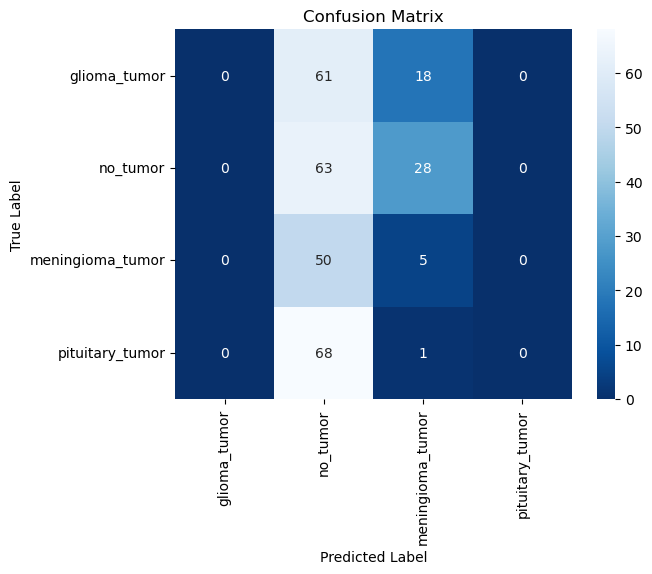

11/11 [==============================] - 1s 99ms/step


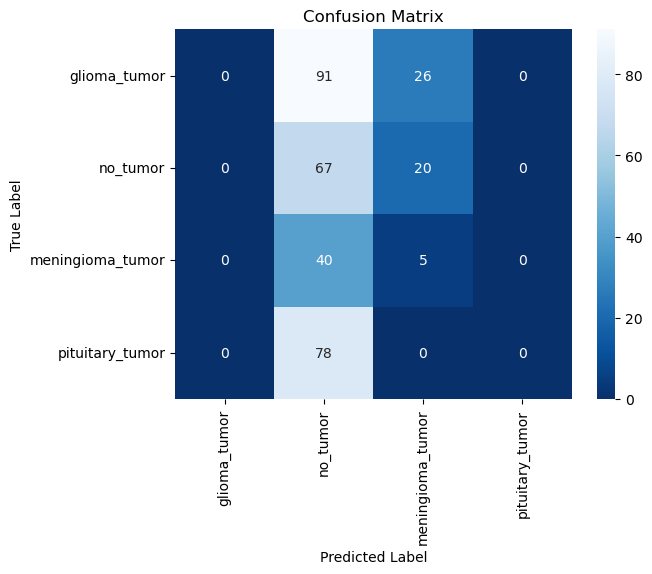

In [66]:
print(f'X_train shape: {(X_train).shape}\n'
      f'y_train shape: {(y_train).shape}\n'
      f'X_test shape: {(X_test).shape}\n'
      f'y_test shape: {(y_test).shape}\n'
      f'X_Valid shape: {(X_valid).shape}\n'
      f'y_valid shape: {(y_valid).shape}')

# Compute the confusion matrix
y_true_valid = np.argmax(y_valid, axis=1)
y_pred_valid = np.argmax(model.predict(X_valid), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_valid,y_pred_valid), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#confusion matrix on test set
y_true_test = np.argmax(y_test, axis=1)
y_pred_test = np.argmax(model.predict(X_test), axis=1) 

heatmap = sns.heatmap(confusion_matrix(y_true_test,y_pred_test), annot=True, fmt='d', cmap='Blues_r',
                      xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Could poor performance be due to adam optimizer changes for mac OS? 

In [67]:
# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor
print(classification_report(y_true_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       117
           1       0.24      0.77      0.37        87
           2       0.10      0.11      0.10        45
           3       0.00      0.00      0.00        78

    accuracy                           0.22       327
   macro avg       0.09      0.22      0.12       327
weighted avg       0.08      0.22      0.11       327



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 15ms/step
Predicted label: no_tumor 
Actual label: glioma_tumor 
Confidence: 26.42%



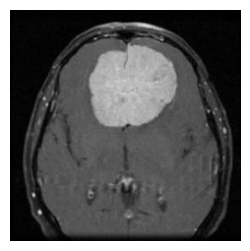

In [68]:
random_index = np.random.randint(0, len(X_test))
random_img = X_test[random_index]  
predictions = model.predict(random_img.reshape(1, 256, 256, 3))  # Reshape and preprocess the image

# Interpret the model's predictions
predicted_class = np.argmax(predictions)  # Get the index of the class with the highest probability
predicted_label = labels[predicted_class]  # Convert class to label
confidence = predictions[0][predicted_class]

actual_index = y_test[random_index]  # Get the one-hot encoded actual class
actual_class = np.argmax(actual_index)  
actual_label = labels[actual_class]  

# Display the image and prediction information
print(f"\033[94mPredicted label: {predicted_label}\033[0m \n\033[92mActual label: {actual_label}\033[0m \n\033[93mConfidence: {confidence*100:.2f}%\033[0m\n")
plt.figure(figsize = (3,3))
plt.imshow(random_img)
plt.axis('off')  
plt.show()

The model poorly performs on validation and test data as shown above. Possible means to improve this could be parameter tuning, augmentation changes, and trying VGG16. 

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

58889256/58889256 [==============================] - 1s 0us/step


NameError: name 'num_classes' is not defined